In [1]:
import autograd
from autograd.builtins import tuple
import autograd.numpy as np

from scipy.integrate import odeint
import matplotlib.pyplot as plt
import random
import pandas as pd

In [2]:
population_data = pd.read_csv('https://raw.githubusercontent.com/quantummind/caltech_covid_19_modeling/master/data/us/demographics/county_populations.csv')
SIR_data = pd.read_csv('https://raw.githubusercontent.com/quantummind/caltech_covid_19_modeling/master/data/us/covid/JHU_daily_US.csv')

In [3]:
SIR_vals = SIR_data.values

In [4]:
def getCountyData(SIR_vals,population_data):
    fipsToTotalPop = {}
    for i in range(len(population_data['FIPS'])):
        fips = population_data['FIPS'][i]
        fipsToTotalPop[fips] = population_data['total_pop'][i]
    
    fipsToSIR = {}
    for i in range(len(SIR_vals)):
        fips = int(SIR_vals[i][0])
        if fips in fipsToTotalPop.keys():
            if fips in fipsToSIR.keys():
                CDR = fipsToSIR[fips]
                CDR.append(SIR_vals[i][1:4])
                fipsToSIR[fips] = CDR
            else:
                CDR = SIR_vals[i][1:4]
                fipsToSIR[fips] = [CDR]
    
    for fips in fipsToSIR.keys():
        fipsToSIR[fips] = np.array(fipsToSIR[fips])
    
    fipsToIndex = {}
    indexToFips = {}
    i = 0
    X = []
    for fips in fipsToSIR.keys():
        fipsToIndex[fips] = i
        indexToFips[i] = fips
        N_0 = fipsToTotalPop[fips]
        CDR = fipsToSIR[fips]
        county_data = []
        for j in range(len(CDR)):
            Q = CDR[j][0] 
            D = CDR[j][1]
            N = N_0 - D
            county_data.append([Q,D,N])
        
        X.append(county_data)
            
        i = i + 1
    
    
    return X, fipsToIndex, indexToFips

In [5]:
X, fipsToIndex, indexToFips = getCountyData(SIR_vals,population_data)

In [153]:
class SPEARQDSolver:
    def __init__(self,x):
        self.numDates = len(x)
        self.t = np.linspace(0, self.numDates-1, self.numDates)
        self.numparams = 7
        self.numstates = 7
        
        Y0Array = np.zeros((self.numparams+1)*self.numstates)
        for i in range(self.numstates):
            try:
                Y0Array[i] = x[0][i]+1
            except:
                Y0Array[i] = 0
                
        self.Y0 = Y0Array
        
        fullX = np.zeros(shape=(self.numDates,self.numstates))
        for i in range(self.numDates):
            for j in range(len(x[0])):
                fullX[i][j] = x[i][j]
                
        self.y_obs = fullX
        self.Y = None
        
        
    def train_model(self, iter_params = .01*np.ones(7),maxiter = 100,max_bad_iters=3, 
                    tolerance = .99,verbose=False,eta=.00000004,weights = np.array([.01,1,0,0,0,0,0])):
        '''
        Train the model on the data to get a model distribution.
        '''
        
        print('Training Model.')
        eta = eta / self.y_obs[len(self.y_obs) -1][1]
        cost = self._Cost(weights*self.y_obs)
        grad_C = autograd.grad(cost)
        min_cost = np.inf
        best_params = np.zeros(self.numparams)
        badCount = 0
        goodCount = 0
        
        for i in range(maxiter):
            sol = odeint(self._system, y0=self.Y0, t=self.t, args=tuple(iter_params))
            Y_full = sol[:,:self.numstates]
            cost_i = cost(weights*Y_full)
            old_params = np.copy(iter_params)
            gradc = grad_C(Y_full)
            
            for i in range(1,self.numparams+1):
                iter_params[i-1] -= eta * (gradc * sol[:,  self.numstates*i:(self.numstates)*(i+1)]).sum() / sol.shape[0]
            
            if(cost_i < min_cost):
                badCount = 0
                goodCount = goodCount + 1 
                min_cost = cost_i
                Y_best = Y_full
                best_params = np.copy(old_params)
    
            else:
                badCount = badCount + 1
                if(badCount >= max_bad_iters or cost_i/min_cost > 2):
                    eta = eta / 2
                    badCount = 0
                    Y_full = Y_best 
                    iter_params = np.copy(best_params)
            
            
            if i % 1 == 0 and verbose:
                print('\t', end='')
                print(cost_i)
                print(iter_params)

        
        print('\tComplete.')
        
        self.Y = Y_best
        print(best_params)
        print(min_cost)
        return best_params 
    
    def compare(self):
        '''
        Compare the model predictions to the test data.
        '''
        
        if self.y_obs is None or self.Y is None:
            print('Model or data does not exist')
            return
        
        plt.figure()
        plt.plot(self.t, self.Y[:,0], label='Q', color='C0', linewidth=5)
        plt.plot(self.t, self.Y[:,1], label='D', color='C1', linewidth=5)
        plt.plot(self.t, self.Y[:,2], label='N', color='C2', linewidth=5)
        
        plt.scatter(self.t, self.y_obs[:,0], marker='.', alpha=0.5, label='Q')
        plt.scatter(self.t, self.y_obs[:,1], marker='.', alpha=0.5, label='D')
        plt.scatter(self.t, self.y_obs[:,2], marker='.', alpha=0.5, label='N')
        plt.legend()
        plt.show()
        
        plt.figure()
        plt.plot(self.t, self.Y[:,1], label='D', color='C1', linewidth=5)
        plt.scatter(self.t, self.y_obs[:,1], marker='.', alpha=0.5, label='D',color='C1')
        plt.legend()
        plt.show()
        
        
    def _f(self, y, t, *params):
        '''
        Set up each differential equation
        '''
        Q = y[0]
        D = y[1]
        N = y[2]
        S = y[3]
        #P = y[4]
        E = y[4]
        A = y[5]
        R = y[6]
        
        #pi = params[0]
        beta_q = params[0]
        beta_a = params[1]
        alpha = params[2] 
        gamma = params[3] 
        delta = params[4] 
        lambda_ar = params[5] 
        lambda_qr = params[6]
        

        dS = -(beta_q * Q/N + beta_a * A/N) * S #- pi * S                  
        dE = (beta_q * Q/N + beta_a * A/N) * S - gamma * E
        dQ = gamma * (1-alpha) * E - (delta + lambda_qr) * Q 
        dA = gamma * alpha * E - lambda_ar * A
        dR = lambda_ar * A + lambda_qr * Q
        dD = delta * Q
        #dP = pi * S
        dN = -dD                                   

        return np.array([dQ, dD, dN, dS, dE, dA, dR]) #dP

    def _system(self, y, t, *params): 
        '''
        Define the system of ODE's and the gradients of each variable.
        '''
        
        # ODE
        dy_dt = self._f(y[:self.numstates], t, *params)

        # Sensitivities
        J = autograd.jacobian(self._f, argnum=0)
        grad_f_params = []
        for i in range(self.numparams):
            grad_f_params.append(autograd.jacobian(self._f, argnum=i+2)) 
        
        grad_y_params = []
        for i in range(self.numparams):
            grad_f_i = grad_f_params[i]
            grad_y_params.append(J(y[:self.numstates], t, *params)@ y[-self.numstates::] + grad_f_i(y[:self.numstates], t, *params))
            
        returnarray = []
        returnarray.append(dy_dt)
        for i in range(0,self.numparams):
            returnarray.append(grad_y_params[i])
            
        return np.concatenate(returnarray)

    def _Cost(self, y_true):
        '''
        Define a cost function based on the true observations.
        '''

        def cost(y_pred):
            err = np.linalg.norm(y_true - y_pred, 2, axis=1)

            return np.sum(err) / y_true.shape[1]

        return cost
    
    def getPreds(self, tRange, *params):
        sol_pred = odeint(self._system, y0=self.Y0, t=tRange, args=params)
        Y_pred = sol_pred[:,:self.numstates]
        deaths = Y_pred.T[1]
        
        return deaths

Training Model.
	36763.04483548396
[1.1  0.6  0.86 1.   0.01 0.05 0.05]
	Complete.
[1.1  0.6  0.86 1.   0.01 0.05 0.05]
36763.04483548396


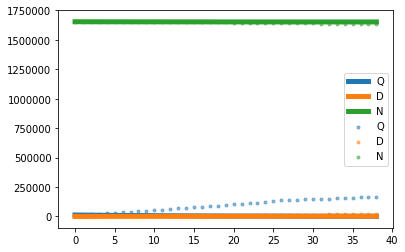

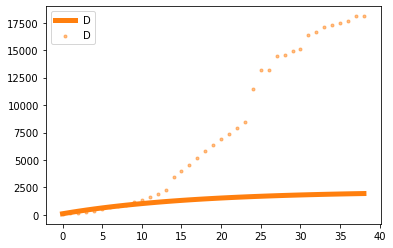

In [174]:
'''beta_q = params[0]
        beta_a = params[1]
        alpha = params[2] 
        gamma = params[3] 
        delta = params[4] 
        lambda_ar = params[5] 
        lambda_qr = params[6]'''
solver = SPEARQDSolver(np.array(X[fipsToIndex[36061]]))
params = solver.train_model(iter_params = np.array([1.1, .6, .86, 1, .01, .05, .05]), 
                            verbose=True, maxiter = 1, eta=0,weights = np.array([0,1,0,0,0,0,0]))
solver.compare()

In [143]:
deaths = solver.getPreds(np.linspace(0,69,70),*params)

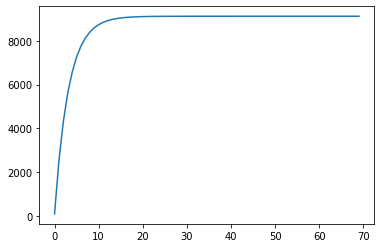

In [144]:
plt.plot(deaths)